## Evaluating and Using Models on New Data

### Load Model

In [1]:
import lightning as L
import torch
import torchmetrics
from shared_utilities import PyTorchMLP, LightningModel, MNISTDataModule

In [7]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
lightning_model = LightningModel.load_from_checkpoint(
    checkpoint_path="model.ckpt", model=pytorch_model)

In [8]:
dm = MNISTDataModule()
dm.setup(stage="test")

## Predictions on New Data

In [9]:
test_data_loader = dm.test_dataloader()

acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

for batch in test_data_loader:
    x, y = batch

    with torch.inference_mode(): # for computational and memory reasons, avoid building the computation graph (not needed when testing/evalutaion)
        y_hat = lightning_model(x)
    
    predicted_labels = torch.argmax(y_hat, dim=1)
    acc(predicted_labels, y)

In [10]:
test_acc = acc.compute()
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.9740 (97.40%)


## Inspection failure cases

In [11]:
class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

In [12]:
import matplotlib.pyplot as plt
from shared_plotting import show_failures

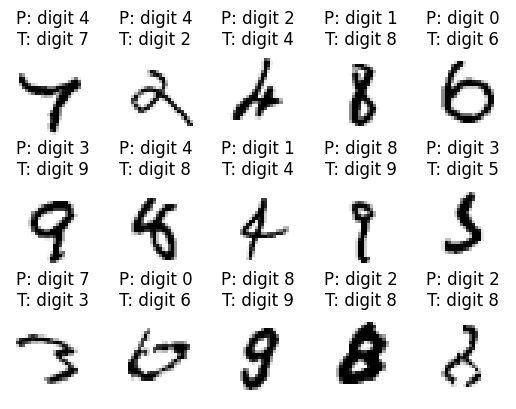

In [14]:
show_failures(
    model=lightning_model, data_loader=test_data_loader, class_dict=class_dict
)

plt.savefig('failures.pdf')

In [ ]:
import matplotlib

from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in dm.test_dataloader():

    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()